# Compare Classification Techniques

Credits: Heavily based on [Customer Churn](http://nbviewer.jupyter.org/github/donnemartin/data-science-ipython-notebooks/blob/master/analyses/churn.ipynb).

Apply the same steps as in the Customer Churn notebook, on the [HR Analytics](https://www.kaggle.com/ludobenistant/hr-analytics) data set.  
Purpose: get familiar with the following classification techniques:
  * Logistic regression
  * Gradient Boosting Classifier
  * Support Vector Machines
  * Random Forest
  * K-nearest-neighbors

Other classifiers can be easily added for comparison.

## Dataset::Inspect

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
employees = pd.read_csv('d:\MyCode\Playground\eMeL\datas\HR_comma_sep.csv')
employees.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
employees.shape

(14999, 10)

In [4]:
employees.mean()

satisfaction_level         0.612834
last_evaluation            0.716102
number_project             3.803054
average_montly_hours     201.050337
time_spend_company         3.498233
Work_accident              0.144610
left                       0.238083
promotion_last_5years      0.021268
dtype: float64

=> 23% of the employees left during the last 5 years...

### How are the features related to one another?

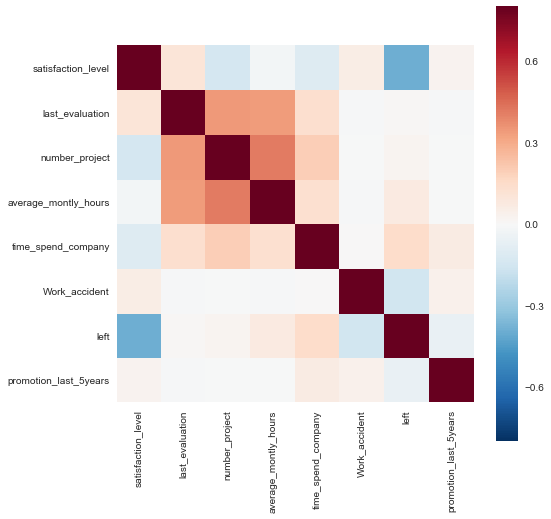

In [5]:
import seaborn as sns

correlation_matrix = employees.corr()
plt.subplots(figsize = (8, 8))

sns.heatmap(correlation_matrix, vmax = .8, square = True)
plt.show()

Notice that the string features are missing from the correlation matrix, i.e. the salary and the department ('sales').

## Dataset::Preprocess

### Convert string features to numbers

In [6]:
# First the salary... 
employees['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [7]:
employees['salary'] = pd.factorize(employees['salary'])[0]

In [8]:
# ... and then the department.
employees['sales'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

In [9]:
employees['sales'] = pd.factorize(employees['sales'])[0]
employees.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,0,0
1,0.80,0.86,5,262,6,0,1,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0


### Standardize, [scale](http://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) data

In [13]:
# First, isolate target data
leave_result = employees['left']
y = np.where(leave_result == 1, 1, 0)
y

array([1, 1, 1, ..., 1, 1, 1])

In [14]:
# Before converting the df. to a matrix, remove the "left" column. It is not a feature, it is the target.
X = employees.drop('left', axis = 1).as_matrix().astype(np.float)
X

array([[ 0.38,  0.53,  2.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.8 ,  0.86,  5.  , ...,  0.  ,  0.  ,  1.  ],
       [ 0.11,  0.88,  7.  , ...,  0.  ,  0.  ,  1.  ],
       ..., 
       [ 0.37,  0.53,  2.  , ...,  0.  ,  4.  ,  0.  ],
       [ 0.11,  0.96,  6.  , ...,  0.  ,  4.  ,  0.  ],
       [ 0.37,  0.52,  2.  , ...,  0.  ,  4.  ,  0.  ]])

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
print("Feature space holds %d observations and %d features" % X.shape)
print("Unique target labels: ", np.unique(y))

Feature space holds 14999 observations and 9 features
Unique target labels:  [0 1]


## Classifiers::Run

(Run, Classifiers, run!)

The data is split into test-train sets using [K-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29#/media/File:K-fold_cross_validation_EN.jpg). This should lead to a more accurate estimate of model prediction performance.

In [21]:
from sklearn.model_selection import KFold

# Helper method to split test-training data using cross-validation.
def run_cv(X, y, clf_class, **kwargs):
    # Construct a kfolds object
    kf = KFold(n_splits = 3, shuffle = True)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        # Initialize a classifier with keyword arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train, y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

### Classifiers::Compare::Accuracy

In [22]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score

def accuracy(y_true, y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print ("Logistic Regression:")
print ("%.3f" % accuracy(y, run_cv(X, y, LR)))
print ("Gradient Boosting Classifier")
print ("%.3f" % accuracy(y, run_cv(X, y, GBC)))
print ("Support vector machines:")
print ("%.3f" % accuracy(y, run_cv(X, y, SVC)))
print ("Random forest:")
print ("%.3f" % accuracy(y, run_cv(X, y, RF)))
print ("K-nearest-neighbors:")
print ("%.3f" % accuracy(y, run_cv(X, y, KNN)))

Logistic Regression:
0.792
Gradient Boosting Classifier
0.976
Support vector machines:
0.961
Random forest:
0.989
K-nearest-neighbors:
0.955


Here's to the **Random Forest**!

## Classifiers::Compare::Confusion Matrix

Reasoning: the accuracy measure above treats false positives and false negatives equally.  
  * Predict that employee will leave + employee stays: mkay, no biggie.
  * Predict that employee will stay + employee leaves: ouch.

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def print_confusion_matrices(confusion_matricies, class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print("\n%s" % classifier)
        print(cm)

y = np.array(y)
class_names = np.unique(y)

confusion_matrices_to_print = [
    ( "Support Vector Machines", confusion_matrix(y, run_cv(X, y, SVC)) ),
    ( "Random Forest", confusion_matrix(y, run_cv(X, y, RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y, run_cv(X, y, KNN)) ),
    ( "Gradient Boosting Classifier", confusion_matrix(y, run_cv(X, y, GBC)) ),
    ( "Logisitic Regression", confusion_matrix(y, run_cv(X, y, LR)) )
]
print_confusion_matrices(confusion_matrices_to_print, class_names)


Support Vector Machines
[[11194   234]
 [  339  3232]]

Random Forest
[[11400    28]
 [  145  3426]]

K-Nearest-Neighbors
[[11046   382]
 [  309  3262]]

Gradient Boosting Classifier
[[11323   105]
 [  247  3324]]

Logisitic Regression
[[10606   822]
 [ 2281  1290]]



Support Vector Machines
[[11181   247]
 [  339  3232]]

Random Forest
[[11402    26]
 [  131  3440]]

K-Nearest-Neighbors
[[11047   381]
 [  305  3266]]

Gradient Boosting Classifier
[[11312   116]
 [  249  3322]]

Logisitic Regression
[[10603   825]
 [ 2277  1294]]


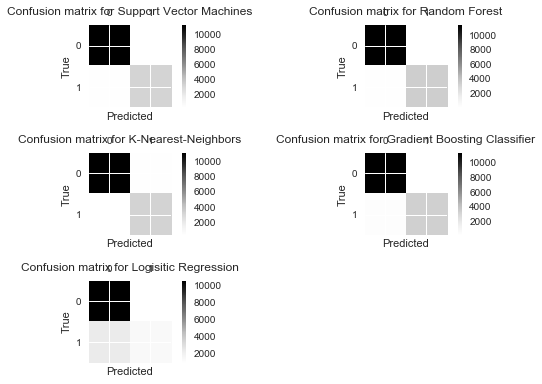

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


def draw_confusion_matrices(confusion_matricies, class_names):
    fig = plt.figure()
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm, pos = cm[0], cm[1], cm[2]
        print("\n%s" % classifier)
        print(cm)
        
        ax = fig.add_subplot(pos, 
                             title = 'Confusion matrix for %s' % classifier, 
                             xlabel = 'Predicted',
                             ylabel = 'True')
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
    plt.tight_layout()
    plt.show()

y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y, run_cv(X, y, SVC)), 321 ),
    ( "Random Forest", confusion_matrix(y, run_cv(X, y, RF)), 322 ),
    ( "K-Nearest-Neighbors", confusion_matrix(y, run_cv(X, y, KNN)), 323 ),
    ( "Gradient Boosting Classifier", confusion_matrix(y, run_cv(X, y, GBC)), 324 ),
    ( "Logisitic Regression", confusion_matrix(y, run_cv(X, y, LR)), 325 )
]

draw_confusion_matrices(confusion_matrices, class_names)

Q1: When an individual leaves, how often does the classifier predict that correctly? A.K.A. *recall* or *sensitivity* or *probability of detection* (that is, the true positive rate).  
A1: Best: Random Forests; So much worse: Logistic Regression.  

Q2: When a classifier predicts that an individual will leave, how oftern does that individual actually leave? A.K.A. *precision*.  
A2: Same.

### Interimary conclusion: accuracy, recall and precision all rank Random Forests above all others.

I believe that, in theory, it should suffice for us to draw the line and go for the Random Forests.  
However, for the sake of learning, we will continue comparing the classifiers.

## Classifiers::Compare::ROC Plots & AUC

The Area Under Curve (AUC) of a Receiver Operating Characteristic (ROC) curve => a single value that represents the expected performance.

Method: plot True Positive Rate (recall / sensitivity / probability of detection) against False Positive Rate (fall-out / probability of false alarm).

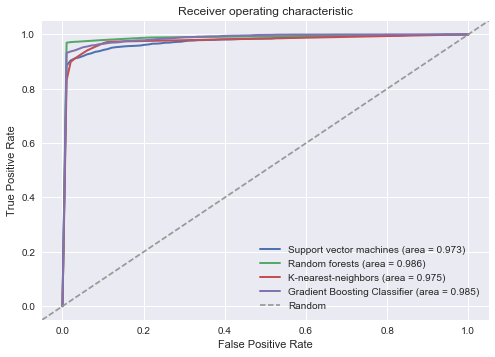

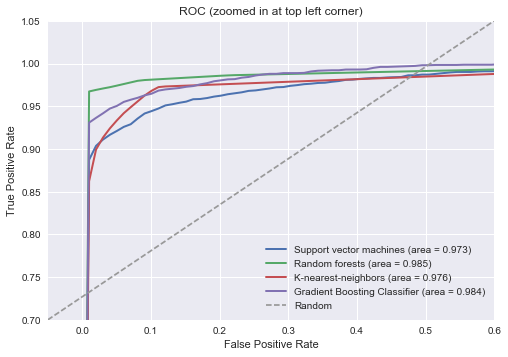

In [33]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc(X, y, clf_class, clf_name, **kwargs):
    kf = KFold(n_splits = 3, shuffle = True)
    y_prob = np.zeros((len(y), 2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        # plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= kf.get_n_splits(X)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, lw = 2, label = '%s (area = %0.3f)' % (clf_name, mean_auc))
    
def plot_all(title, max_x, min_y):
    plot_roc(X, y, SVC, "Support vector machines", probability=True)
    plot_roc(X, y, RF, "Random forests", n_estimators=18)
    plot_roc(X, y, KNN, "K-nearest-neighbors")
    plot_roc(X, y, GBC, "Gradient Boosting Classifier")

    plt.plot([-0.05, max_x], [min_y, 1.05], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim(-0.05, max_x)
    plt.ylim(min_y, 1.05)      
    #plt.xlim([-0.05, 1.05])
    #plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
plt.figure(1)
plot_all('Receiver operating characteristic', 1.05, -0.05)

plt.figure(2)
plot_all('ROC (zoomed in at top left corner)', 0.6, 0.7)
